In [ ]:
# !pip install wordcloud
# !pip install git+https://github.com/minimaxir/textgenrnn.git

     |████████████████████████████████| 461 kB 3.6 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import random

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import pickle
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from pylab import rcParams
import warnings

warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /home/htet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/htet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/htet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/htet/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Load data
path = "/home/htet/Documents/backup/sentiment_analysis_of_amazon_product_reviews"
reviews = pd.read_csv(path + r'/data/amazon_reviews.csv')
print("Number of records:", len(reviews))
reviews.head()

Number of records: 568454


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
reviews.Text[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
# Check NULL values in the columns of "Score" and "Text"
print('Number of NULL records in Score:', reviews['Score'].isnull().sum())
print('Number of NULL records in Text:', reviews['Text'].isnull().sum())

Number of NULL records in Score: 0
Number of NULL records in Text: 0


In [ ]:
# Delete redundant columns
cols_deleted = ["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Time", "Summary"]
if all(col in reviews.columns for col in cols_deleted):
    reviews = reviews.drop(cols_deleted, axis=1)

In [ ]:
# The number of words per review
words_per_review = reviews.Text.apply(lambda x: len(x.split(" ")))
print('Average words per review:', words_per_review.mean())

Average words per review: 82.00552199474363


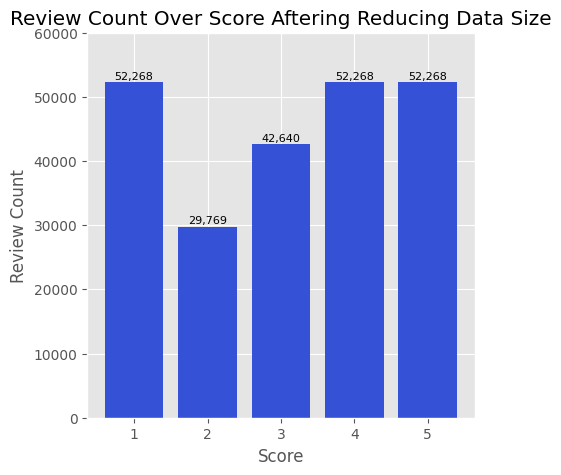

In [ ]:
# Separate the scores into new DataFrames
reviews_1 = reviews[reviews["Score"]==1]
reviews_2 = reviews[reviews["Score"]==2]
reviews_3 = reviews[reviews["Score"]==3]
reviews_4 = reviews[reviews["Score"]==4]
reviews_5 = reviews[reviews["Score"]==5]

# Randomly reduce the size of score 4 and 5 without replacement
reviews_4 = reviews_4.sample(len(reviews_1), replace=False, random_state=42)
reviews_5 = reviews_5.sample(len(reviews_1), replace=False, random_state=42)

reduced_size_reviews = pd.concat([reviews_1, reviews_2, reviews_3, reviews_4, reviews_5], ignore_index=True)
reduced_size_review_counts = reduced_size_reviews["Score"].value_counts()

# Plot the labels over score counts
fig, ax = plt.subplots(figsize=(5,5))
bar_container = ax.bar(labels, reduced_size_review_counts, align='center', color='#3552d7')
ax.set(xlabel='Score', ylabel='Review Count', title='Review Count Over Score Aftering Reducing Data Size', ylim=(0,60000))
ax.xaxis.set_major_locator(plt.FixedLocator(labels))
ax.xaxis.set_major_formatter(plt.FixedFormatter(labels))

for i, bar in enumerate(bar_container):
    ax.text(bar.get_x() + bar.get_width()/2 , bar.get_height()+500,
            '{:,.0f}'.format(reduced_size_review_counts.iloc[i]), ha='center', rotation=360, fontsize=8, linespacing=2)

plt.show()

In [ ]:
# Split train, validation and test data on each score
reviews_1_test = reviews_1.sample(round(len(reviews_1)*20/100), replace=False, random_state=42)
reviews_1_train = reviews_1.drop(reviews_1_test.index)
reviews_1_val = reviews_1_train.sample(round(len(reviews_1_train)*20/100), replace=False, random_state=42)
reviews_1_train = reviews_1_train.drop(reviews_1_val.index)

reviews_2_test = reviews_2.sample(round(len(reviews_2)*20/100), replace=False, random_state=42)
reviews_2_train = reviews_2.drop(reviews_2_test.index)
reviews_2_val = reviews_2_train.sample(round(len(reviews_2_train)*20/100), replace=False, random_state=42)
reviews_2_train = reviews_2_train.drop(reviews_2_val.index)

reviews_4_test = reviews_4.sample(round(len(reviews_4)*20/100), replace=False, random_state=42)
reviews_4_train = reviews_4.drop(reviews_4_test.index)
reviews_4_val = reviews_4_train.sample(round(len(reviews_4_train)*20/100), replace=False, random_state=42)
reviews_4_train = reviews_4_train.drop(reviews_4_val.index)

reviews_5_test = reviews_5.sample(round(len(reviews_5)*20/100), replace=False, random_state=42)
reviews_5_train = reviews_5.drop(reviews_5_test.index)
reviews_5_val = reviews_5_train.sample(round(len(reviews_5_train)*20/100), replace=False, random_state=42)
reviews_5_train = reviews_5_train.drop(reviews_5_val.index)

# Concatenate train, validation and test data
resampled_review_train = pd.concat([reviews_1_train, reviews_2_train, reviews_4_train, reviews_5_train], ignore_index=True)
resampled_review_val = pd.concat([reviews_1_val, reviews_2_val, reviews_4_val, reviews_5_val], ignore_index=True)
resampled_review_test = pd.concat([reviews_1_test, reviews_2_test, reviews_4_test, reviews_5_test], ignore_index=True)

print("Train size: ", len(resampled_review_train))
print("Validation size: ", len(resampled_review_val))
print("Test size: ", len(resampled_review_test))

Train size:  119405
Validation size:  29852
Test size:  37316


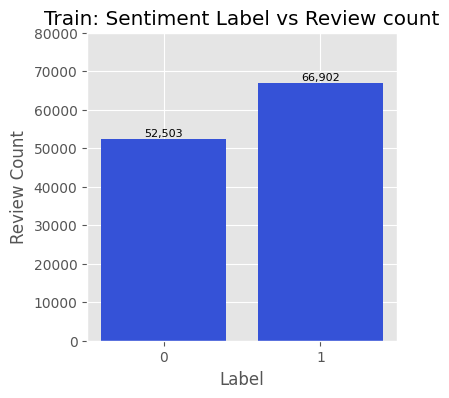

In [ ]:
# Standardize the ratings for sentiment analysis
resampled_review_train['Sentiment'] = np.where(resampled_review_train.Score > 3, 'positive', 'negative')
resampled_review_train['Sentiment'] = resampled_review_train['Sentiment'].replace({'negative': 0, 'positive': 1})
review_count_train = resampled_review_train['Sentiment'].value_counts()
sentiment_label_train = review_count_train.index.values

resampled_review_val['Sentiment'] = np.where(resampled_review_val.Score > 3, 'positive','negative')
resampled_review_val['Sentiment'] = resampled_review_val['Sentiment'].replace({'negative': 0, 'positive': 1})

resampled_review_test['Sentiment'] = np.where(resampled_review_test.Score > 3, 'positive', "negative")
resampled_review_test['Sentiment'] = resampled_review_test['Sentiment'].replace({'negative': 0, 'positive': 1})

# Plot sentiment ratings for train data
fig, ax = plt.subplots(figsize=(4,4))
bar_container = ax.bar(sentiment_label_train, review_count_train, align='center', color='#3552d7')
ax.set(xlabel='Label', ylabel='Review Count', title='Train: Sentiment Label vs Review count', ylim=(0,80000))
ax.xaxis.set_major_locator(plt.FixedLocator(sentiment_label_train))
ax.xaxis.set_major_formatter(plt.FixedFormatter(sentiment_label_train))

for i, bar in enumerate(bar_container):
    ax.text(bar.get_x() + bar.get_width()/2 , bar.get_height()+700, '{:,.0f}'.format(review_count_train.iloc[i]) ,ha='center', rotation=360, fontsize=8, linespacing=2)

plt.show()

In [ ]:
# Convert words to lower case
resampled_review_train['Text'] = resampled_review_train['Text'].str.lower()

# Remove special characters
resampled_review_train['Text'] = resampled_review_train['Text'].str.replace(r'[^A-Za-z0-9 ]+', '')
resampled_review_val['Text'] = resampled_review_val['Text'].str.replace(r'[^A-Za-z0-9 ]+', '')
resampled_review_test['Text'] = resampled_review_test['Text'].str.replace(r'[^A-Za-z0-9 ]+', '')
print("\n***Review after converting to lower case and removing special characters***")
print(resampled_review_train['Text'][0])

# Remove stopwords and lemmatize the words
stop_words = stopwords.words('english')
print("\n***Stopwords***")
print(stop_words)

lemmatizer = WordNetLemmatizer()

resampled_review_train['Text'] = resampled_review_train['Text'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(review) if word not in stop_words]))
resampled_review_val['Text'] = resampled_review_val['Text'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(review) if word not in stop_words]))
resampled_review_test['Text'] = resampled_review_test['Text'].apply(lambda review: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(review) if word not in stop_words]))
print("\n***Reviews after removing stopwords and lemmating the words***")
resampled_review_train['Text'][0]


***Review after converting to lower case and removing special characters***
product arrived labeled as jumbo salted peanuts...the peanuts were actually small sized unsalted. not sure if this was an error or if the vendor intended to represent the product as "jumbo".

***Stopwords***
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 

"product arrive label jumbo salt peanuts ... peanuts actually small size unsalted . sure error vendor intend represent product `` jumbo '' ."

In [ ]:
# Delete redundant column
resampled_review_train = resampled_review_train.drop('Score', axis=1)
resampled_review_val = resampled_review_val.drop('Score', axis=1)
resampled_review_test = resampled_review_test.drop('Score', axis=1)
resampled_review_train.head()

,Text,Sentiment
0,product arrive label jumbo salt peanuts ... pe...,0
1,"candy red , flavor . plan chewy . would never buy",0
2,"oatmeal good . mushy , soft , n't like . quake...",0
3,single sell $ 2.50 - $ 3.36 store 1 box 24 sin...,0
4,seriously product tasteless come . much better...,0


In [ ]:
# Check NULL values in columns
print('***Train***')
print('Number of NULL records in Text: ', resampled_review_train.Text.isnull().sum())
print('Number of NULL records in Sentiment: ', resampled_review_train.Sentiment.isnull().sum())
print('***Validation***')
print('Number of NULL records in Text: ', resampled_review_val.Text.isnull().sum())
print('Number of NULL records in Sentiment: ', resampled_review_val.Sentiment.isnull().sum())
print('***Test***')
print('Number of NULL records in Text: ', resampled_review_test.Text.isnull().sum())
print('Number of NULL records in Sentiment: ', resampled_review_test.Sentiment.isnull().sum())

***Train***
Number of NULL records in Text:  0
Number of NULL records in Sentiment:  0
***Validation***
Number of NULL records in Text:  0
Number of NULL records in Sentiment:  0
***Test***
Number of NULL records in Text:  0
Number of NULL records in Sentiment:  0


In [ ]:
# Random resampling the data
resampled_review_train = resampled_review_train.sample(len(resampled_review_train), replace=False, random_state=42)
resampled_review_val = resampled_review_val.sample(len(resampled_review_val), replace=False, random_state=42)
resampled_review_test = resampled_review_test.sample(len(resampled_review_test), replace=False, random_state=42)

In [ ]:
# Split X and y data
X_train = resampled_review_train['Text']
y_train = resampled_review_train['Sentiment']
X_val = resampled_review_val['Text']
y_val = resampled_review_val['Sentiment']
X_test = resampled_review_test['Text']
y_test = resampled_review_test['Sentiment']

X_train_under shape:  (105006,)
y_train_under shape:  (105006,)

***Label Distribution of Y Train After Oversampling***


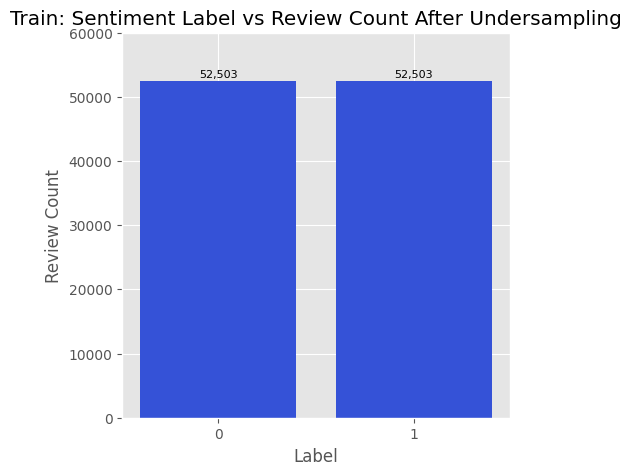

In [ ]:
# Undersample train data
X_train = np.array(X_train).reshape(-1, 1)
under = RandomUnderSampler(sampling_strategy='all', random_state=42)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
X_train_under = np.array(X_train_under).reshape(-1)
X_train_under = pd.Series(X_train_under)

print("X_train_under shape: ", X_train_under.shape)
print("y_train_under shape: ", y_train_under.shape)
print("\n***Label Distribution of Y Train After Oversampling***")

y_train_under_counts = y_train_under.value_counts()

# Plot sentiment ratings for train data
fig, ax = plt.subplots(figsize=(5,5))
bar_container = ax.bar(sentiment_label_train, y_train_under_counts, align='center', color='#3552d7')
ax.set(xlabel='Label', ylabel='Review Count', title='Train: Sentiment Label vs Review Count After Undersampling', ylim=(0,60000))
ax.xaxis.set_major_locator(plt.FixedLocator(sentiment_label_train))
ax.xaxis.set_major_formatter(plt.FixedFormatter(sentiment_label_train))

for i, bar in enumerate(bar_container):
    ax.text(bar.get_x() + bar.get_width()/2 , bar.get_height()+500, '{:,.0f}'.format(y_train_under_counts.iloc[i]) ,ha='center', rotation=360, fontsize=8, linespacing=2)

plt.show()

In [ ]:
# Train TF-IDF model to vectorize input data
tfidf = TfidfVectorizer(tokenizer= word_tokenize, ngram_range=(1,1), lowercase=False)
X_train_tfidf = tfidf.fit_transform(X_train_under)

tfidf_path = path + "/model_tfidf.pkl"

# Save the model
with open(tfidf_path, 'wb') as f:
    pickle.dump(tfidf, f)

# Transform the data
X_train_tfidf = tfidf.transform(X_train_under)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)
X_train_tfidf

<105006x88788 sparse matrix of type '<class 'numpy.float64'>'
	with 3568620 stored elements in Compressed Sparse Row format>

In [ ]:
# Normalize matrices
scaler = MaxAbsScaler()
X_train_norm = scaler.fit_transform(X_train_tfidf)
X_val_norm = scaler.transform(X_val_tfidf)
X_test_norm = scaler.transform(X_test_tfidf)

In [ ]:
# Create Logistic Regression model
model_logreg = LogisticRegression()

param_grid_loreg = {
    'solver': ['sag'],
    'penalty': ['l2'],
    'tol': [0.01, 0.001, 0.0001],
    'max_iter': [30, 50, 100, 200],
    'C': [0.1, 1, 5, 10, 15],
    'random_state': [42]
}

# Train logistic regression model
grid_search_logreg = GridSearchCV(model_logreg, param_grid_loreg, scoring='accuracy', cv=5)
grid_search_logreg.fit(X_train_norm, y_train_under)

best_params_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_
print("Best Parameters:", best_params_logreg)
print("Best Score:", best_score_logreg)

Best Parameters: {'C': 5, 'max_iter': 30, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.001}
Best Score: 0.8870921655768352


In [ ]:
# Create Linear Support Vector Machine model
model_lsvc = LinearSVC()

param_grid_lsvc = {
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'tol': [0.01, 0.001, 0.0001],
    'max_iter': [30, 50, 100, 200],
    'C': [0.1, 1, 5, 10, 15],
    'random_state': [42],
    'multi_class': ['ovr']
}

# Train logistic regression model
grid_search_lsvc = GridSearchCV(model_lsvc, param_grid_lsvc, scoring='accuracy', cv=5)
grid_search_lsvc.fit(X_train_norm, y_train_under)

best_params_lsvc = grid_search_lsvc.best_params_
best_score_lsvc = grid_search_lsvc.best_score_
print("Best Parameters:", best_params_lsvc)
print("Best Score:", best_score_lsvc)

Best Parameters: {'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 30, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'tol': 0.01}
Best Score: 0.8864064970926762


In [ ]:
# Create Bernoulli Naive Bayes model
model_bnb = BernoulliNB()

param_grid_bnb = {
    'alpha': [0.1, 1, 10, 15, 20, 50]
}

# Train logistic regression model
grid_search_bnb = GridSearchCV(model_bnb, param_grid_bnb, scoring='accuracy', cv=5)
grid_search_bnb.fit(X_train_norm, y_train_under)

best_params_bnb = grid_search_bnb.best_params_
best_score_bnb = grid_search_bnb.best_score_
print("Best Parameters:", best_params_bnb)
print("Best Score:", best_score_bnb)

Best Parameters: {'alpha': 0.1}
Best Score: 0.8372473776433417


In [ ]:
# Create Random Forest model
model_rfc = RandomForestClassifier()

param_grid_rfc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [50, 100, 150],
    'n_estimators': [50, 100, 200],
    'random_state': [42]
}

# Train logistic regression model
grid_search_rfc = GridSearchCV(model_rfc, param_grid_rfc, scoring='accuracy', cv=5)
grid_search_rfc.fit(X_train_norm, y_train_under)

best_params_rfc = grid_search_rfc.best_params_
best_score_rfc = grid_search_rfc.best_score_
print("Best Parameters:", best_params_rfc)
print("Best Score:", best_score_rfc)

Best Parameters: {'criterion': 'gini', 'max_depth': 150, 'n_estimators': 200, 'random_state': 42}
Best Score: 0.8913681166120572
